# Cargamos utilidades de colab y Talib


In [24]:
# !git clone https://github.com/b0tm4r/RNN---Divisas.git
from google.colab import drive # Para cargar el disco
from google.colab import files # Para manejar los archivos y, por ejemplo, exportar a su navegador
import glob # Para manejar los archivos y, por ejemplo, exportar a su navegador

drive.mount('/content/drive')
!ls '/content/drive/My Drive' 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'


## TaLib

In [25]:
import os
# download TA-Lib 
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!tar xvzf ta-lib-0.4.0-src.tar.gz
os.chdir('ta-lib') # co-lab no admite cd
!./configure --prefix=/usr
!make
!make install
# wait ~ 30s
os.chdir('../')
!pip install TA-Lib

--2021-01-13 17:05:22--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-01-13 17:05:23--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://netactuate.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-01-13 17:05:23--  https://netactuate.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving netactuate

# Librerías

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import talib
import pickle

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model

Importar el dataset de entrenamiento

In [27]:
def get_dataframe(dir_path, valor):
    df1 = pd.read_csv(os.path.join(dir_path,'datasets',
                                   "{}.csv".format(valor)))
    df2 = pd.read_csv(os.path.join(dir_path,'datasets',
                                   "{}-total.csv".format(valor)))
    df = pd.concat([df1, df2], ignore_index=True)
    df = df.drop_duplicates(['Fecha'])
    # Datafame reverse xq los datos vienen de mas a menos y reindexamos
    
    df = df.iloc[::-1]
    df = df.reset_index(drop=True)
    # Close
    df['Close'] = df.iloc[:,1:2]
    df['Close'] = df['Close'].apply(lambda x: x.replace(',','.')).astype(float)
    # Open
    df['Open'] = df.iloc[:,2:3]
    df['Open'] = df['Open'].apply(lambda x: x.replace(',','.')).astype(float)
    # High
    df['High'] = df.iloc[:,3:4]
    df['High'] = df['High'].apply(lambda x: x.replace(',','.')).astype(float)
    # Low
    df['Low'] = df.iloc[:,4:5]
    df['Low'] = df['Low'].apply(lambda x: x.replace(',','.')).astype(float)
    # RSI 14
    rsi = talib.RSI(df['Close'])
    df['Rsi'] = rsi
    # Selección de columnas
    df = df.iloc[:,[0,6,7,8,9,10]]
    return df

## Variables de entrada

periodos = numero de periodos de entrenamiento

In [28]:
dir_path = '/content/drive/My Drive/Colab Notebooks/RNN-Divisas'
periodos = 60 
valor = 'EUR-USD'

## Información sobre el modelo

In [29]:
pickle_file = os.path.join(dir_path,'models',
                            "{}-precio-rsi.pk".format(valor))
info = pickle.load(open(pickle_file,'rb'))

In [30]:
info['summary']

['Model: "sequential_2"',
 '_________________________________________________________________',
 'Layer (type)                 Output Shape              Param #   ',
 '=================================================================',
 'lstm_8 (LSTM)                (None, 60, 50)            10600     ',
 '_________________________________________________________________',
 'dropout_8 (Dropout)          (None, 60, 50)            0         ',
 '_________________________________________________________________',
 'lstm_9 (LSTM)                (None, 60, 50)            20200     ',
 '_________________________________________________________________',
 'dropout_9 (Dropout)          (None, 60, 50)            0         ',
 '_________________________________________________________________',
 'lstm_10 (LSTM)               (None, 60, 50)            20200     ',
 '_________________________________________________________________',
 'dropout_10 (Dropout)         (None, 60, 50)            0      

# Test

La red se ha creado con dos capas de profundidad

La primera corresponde al precio, en posicion 1:2 del dataset

La segunda corresponde al rsi, en posicion 5:6 del dataset

In [31]:
data_position = [[1,2],[5,6]]

modelo = load_model(os.path.join(dir_path,'models',
                                 "{}-precio-rsi.h5".format(valor)))
dataset_train = get_dataframe(dir_path,valor)
dataset_train = dataset_train.dropna()

dataset_train.head(3)

testing_set = dataset_train.iloc[-periodos:,
                   data_position[0][0]:data_position[0][1]
              ].values
real_stock_price = testing_set

sc = [] 
X_values = []
for i in range(0,len(data_position)):
    sc.append(MinMaxScaler(feature_range = (0, 1)))
    values = dataset_train.iloc[
                len(dataset_train) - len(testing_set) - periodos:, 
                data_position[i][0]:data_position[i][1]
             ].values
    values = values.reshape(-1,1)
    values = sc[i].fit_transform(values)
    X_values.append(values)

X_test_list = []
for i in range(0,len(data_position)):
    X_test_data = []
    for x in range(periodos, X_values[i].shape[0]):
        X_test_data.append(X_values[i][x-periodos:x, 0])
    
    X_test_list.append(X_test_data)
        
X_test_np = []
for i in range(0,len(data_position)):
    X_test_np.append( np.array(X_test_list[i]) )

## axis = dimensiones
X_test = np.stack(X_test_np, axis=len(data_position))  

predicted_stock_price = modelo.predict(X_test)
predicted_stock_price = sc[0].inverse_transform(predicted_stock_price)

## Visualizar los Resultados


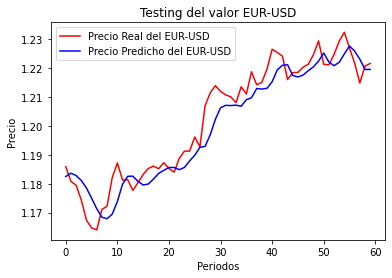

In [32]:
plt.plot(real_stock_price, color = 'red',
         label = 'Precio Real del {}'.format(valor))
plt.plot(predicted_stock_price, color = 'blue',
         label = 'Precio Predicho del {}'.format(valor))
plt.title("Testing del valor {}".format(valor))
plt.xlabel("Periodos")
plt.ylabel("Precio")
plt.legend()
plt.savefig(os.path.join(dir_path,'models','{}-test.jpg'.format(valor)))
plt.show()